In [ ]:
import sys, argparse
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import re
from collections import Counter, defaultdict
import operator
import nltk
import csv
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from pandas import option_context
import math
from scipy.stats import norm

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
trainingFile = "/content/drive/MyDrive/AP4/train.txt"
evaluationFile = "/content/drive/MyDrive/AP4/dev.txt"
testFile = "/content/drive/MyDrive/AP4/test.txt"

In [ ]:
!pip install hatesonar
!pip install "scikit_learn==0.22.2.post1"

In [ ]:
#source: https://github.com/Hironsan/HateSonar
from hatesonar import Sonar
sonar = Sonar()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.logistic module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py

In [ ]:
######################################################################
## Do not edit this block of code.
## This defines the classification class which
## loads the data and sets up the model.
######################################################################

class Classifier:

    def __init__(self, feature_method, L2_regularization_strength=1.0, min_feature_count=1):
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.log_reg = None
        self.L2_regularization_strength=L2_regularization_strength
        self.min_feature_count=min_feature_count

        self.trainX, self.trainY, self.trainOrig = self.process(trainingFile, training=True)
        self.devX, self.devY, self.devOrig = self.process(evaluationFile, training=False)
        self.testX, _, self.testOrig = self.process(testFile, training=False)

    # Read data from file
    def load_data(self, filename):
        data = []
        with open(filename, encoding="utf8") as file:
            for line in file:
                cols = line.split("\t")
                idd = cols[0]
                label = cols[1]
                text = cols[2]

                data.append((idd, label, text))

        return data

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for idd, label, text in data:
            feats = self.feature_method(text)
            featurized_data.append((label, feats))
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, dataFile, training = False):
        original_data = self.load_data(dataFile)
        data = self.featurize(original_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for label, feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (label, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = label

        return X, Y, original_data

    def load_test(self, dataFile):
        data = self.load_data(dataFile)
        data = self.featurize(data)

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        Y = [None]*D
        for idx, (data_id, feats) in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]
            Y[idx] = data_id

        return X, Y

    # Train model and evaluate on held-out data
    def evaluate(self):
        (D,F) = self.trainX.shape
        self.log_reg = linear_model.LogisticRegression(C = self.L2_regularization_strength, max_iter=1000)
        self.log_reg.fit(self.trainX, self.trainY)
        training_accuracy = self.log_reg.score(self.trainX, self.trainY)
        development_accuracy = self.log_reg.score(self.devX, self.devY)
        print("Method: %s, Features: %s, Train accuracy: %.3f, Dev accuracy: %.3f" % (self.feature_method.__name__, F, training_accuracy, development_accuracy))
        return development_accuracy

    # Predict labels for new data
    def predict(self):
        predX = self.log_reg.predict(self.testX)

        with open("%s_%s" % (self.feature_method.__name__, "predictions.csv"), "w", encoding="utf8") as out:
            writer=csv.writer(out)
            writer.writerow(["Id", "Expected"])
            for idx, data_id in enumerate(self.testX):
                writer.writerow([self.testOrig[idx][0], predX[idx]])
        out.close()


    def printWeights(self, n=10):

        reverse_vocab=[None]*len(self.log_reg.coef_[0])
        for k in self.feature_vocab:
            reverse_vocab[self.feature_vocab[k]]=k

        # binary
        if len(self.log_reg.classes_) == 2:
              weights=self.log_reg.coef_[0]

              cat=self.log_reg.classes_[1]
              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

              cat=self.log_reg.classes_[0]
              for feature, weight in list(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1)))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()

        # multiclass
        else:
          for i, cat in enumerate(self.log_reg.classes_):

              weights=self.log_reg.coef_[i]

              for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
                  print("%s\t%.3f\t%s" % (cat, weight, feature))
              print()



In [ ]:
data = open("/content/drive/MyDrive/AP4/vader_lexicon.txt", 'r')
vader_dict = {}
for line in data:
  arr = line.split()[:2]
  if len(arr) == 2:
    key, value = arr
    vader_dict[key] = value
#mean sentiment rating

In [ ]:
text = open(testFile, 'r')
# more = []
from nltk.util import ngrams
#for line in text:
#   words = nltk.word_tokenize(line)
#   _2gram = [' '.join(e) for e in ngrams(words, 2)]
# _2gram[0].lower()

In [ ]:
test = pd.read_csv(testFile, sep="\t", header=None)
test.head()
train = pd.read_csv(trainingFile, sep="\t", header=None)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

count = CountVectorizer()
word_count=count.fit_transform(train[2])

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count.get_feature_names(),columns=["idf_weights"])
feats= {}
df_idf = df_idf.reset_index()
for i in range(len(df_idf['index'])):
  feats[df_idf['index'][i]] = df_idf['idf_weights'][i]
feats

{'000': 5.787491742782046,
 '0022': 6.703782474656201,
 '00224490609552336': 6.703782474656201,
 '01': 5.451019506160833,
 '011': 6.703782474656201,
 '02': 5.451019506160833,
 '03': 6.0106352940962555,
 '04': 6.298317366548036,
 '05': 6.298317366548036,
 '06': 6.0106352940962555,
 '07': 6.703782474656201,
 '08': 6.298317366548036,
 '09': 6.298317366548036,
 '0_pnoir5': 6.703782474656201,
 '0camq4audahckewjwjkhgsr31ahuaaaaahqaaaaaqaq': 6.298317366548036,
 '0muuwmd': 6.703782474656201,
 '0nikr': 6.703782474656201,
 '0x4rwrbjusi': 6.703782474656201,
 '10': 3.7593434954897607,
 '100': 4.624340932976365,
 '1000': 6.0106352940962555,
 '1000s': 6.703782474656201,
 '1002': 6.703782474656201,
 '1007': 6.703782474656201,
 '1016': 6.703782474656201,
 '1022': 6.703782474656201,
 '1024': 6.703782474656201,
 '1037': 6.703782474656201,
 '104274': 6.703782474656201,
 '1080': 6.703782474656201,
 '1097': 6.703782474656201,
 '10lbs': 6.703782474656201,
 '11': 5.0943445622221,
 '110002873': 6.703782474656

In [ ]:
def features(text):
    # Here the `feats` dict should contain the features -- the key should be the feature name,
    # and the value is the feature value.  See `simple_featurize` for an example.
    num_am, num_inst, num_inter, num_internal, num_ben, num_neu, num_hos = 0,0,0,0,0,0,0

    feats = {}
    total = 0
    scores = []
    words = nltk.word_tokenize(text)
    _2gram = [' '.join(e) for e in ngrams(words, 2)]
    two_words = [word.lower() for word in _2gram if word.isalpha()]
    words = [word.lower() for word in words if word.isalpha()]

    #riti
    # total_word_length = len(text.replace(" ", ""))
    # feats["average_word_length"] =  total_word_length / len(words)
    # feats["hate_speech"] = sonar.ping(text=text)["classes"][1]['confidence']
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.feature_extraction.text import TfidfVectorizer

    count = CountVectorizer()
    word_count=count.fit_transform(words)

    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count)
    df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count.get_feature_names(),columns=["idf_weights"])
    feats= {}
    df_idf = df_idf.reset_index()
    for i in range(len(df_idf['index'])):
      feats[df_idf['index'][i]] = df_idf['idf_weights'][i]

    benevelont_words = ["should","physical", "sex", "hot", "help", "guide", "body", "boobs","butt", "objectify"]
    institutional_words = ["salary", "income", "income gap","school", "government", "business", "institution", "job", "workplace", "college", "military", "law"]
    interpersonal_words = ["story", "my", "mean", "bitch", "she", "her", "friend", "girlfriend", "sister", "wife", "boss", "girl"]
    internalized_words = ["as", "as a" , "I", "me", "personally", "personal", "internally"]
    ambivalent_words =  ['virgin', 'home', "beautiful", "nice", "kind", "wholesome", "cute", "soft", "sweet", "sensitive", "vulnerable", "protect", "smart"]
    hostile_words = ["all", "every", "hate women","hate woman","stupid", "dumb", "hate", "incapable", "inferior", "feminazi", "ignorant", "blind", "meninist", "weak", "unfair", "angry", "misandrist"]

    for word in words:
      #BOW
      feats[word] = 1
      #zain
      if word in vader_dict:
          try:
              total = float(vader_dict.get(word))
          except:
              total = 0
      scores.append(total)
      #michelle
      if word in benevelont_words:
          feats["Benevelont"] = 1
      if word in institutional_words:
          feats["Institutional"] = 1
      if word in interpersonal_words:
          feats["interpersonal"] = 1
      if word in internalized_words:
          feats["Internalized"] =1
      if word in ambivalent_words:
          feats["Ambivalent"] = 1
      if word in hostile_words and word != 'I' and word != 'me':
          feats["Hostile"] = 1
      if word not in benevelont_words or word not in institutional_words or word not in interpersonal_words or word not in internalized_words or word not in ambivalent_words or word not in hostile_words:
          feats["Neutral"] = 1

    for word in two_words:
      if word in benevelont_words:
          feats["Benevelont"] = 1
      if word in institutional_words:
          feats["Institutional"] = 1
      if word in interpersonal_words:
          feats["interpersonal"] = 1
      if word in internalized_words:
          feats["Internalized"] =1
      if word in ambivalent_words:
          feats["Ambivalent"] = 1
      if word in hostile_words and word not in interpersonal_words:
          feats["Hostile"] = 1
      if word not in benevelont_words or word not in institutional_words or word not in interpersonal_words or word not in internalized_words or word not in ambivalent_words or word not in hostile_words:
          feats["Neutral"] = 1

    tot = np.average(scores)
    if tot > 0:
      feats['text_avg_positive'] = tot
    if tot < 0:
      feats['text_avg_negative'] = -tot #positive high value for texts with high neg score

    return feats

In [ ]:
######################################################################
## Do not edit this block of code, except for the L2_regularization_strength and min_feature_count parameters
######################################################################

classifier = Classifier(features, L2_regularization_strength=1.5, min_feature_count=1)
development_accuracy = classifier.evaluate()
#generate .csv file with prediction output on test data
#classifier.predict()

Method: features, Features: 8736, Train accuracy: 0.998, Dev accuracy: 0.720


In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
accuracy = development_accuracy
lower, upper=confidence_intervals(accuracy, len(classifier.devY), .95)
print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))

classifier.printWeights(n=25)

Test accuracy for best dev model: 0.720, 95% CIs: [0.658 0.782]

ambivalent sexism	0.485	will
ambivalent sexism	0.420	woman
ambivalent sexism	0.402	women
ambivalent sexism	0.340	how
ambivalent sexism	0.335	Ambivalent
ambivalent sexism	0.283	get
ambivalent sexism	0.281	because
ambivalent sexism	0.278	am
ambivalent sexism	0.277	home
ambivalent sexism	0.275	of
ambivalent sexism	0.262	reject
ambivalent sexism	0.248	world
ambivalent sexism	0.239	tradwife
ambivalent sexism	0.237	talk
ambivalent sexism	0.232	third
ambivalent sexism	0.230	no
ambivalent sexism	0.229	more
ambivalent sexism	0.224	t
ambivalent sexism	0.224	big
ambivalent sexism	0.220	mad
ambivalent sexism	0.220	tradwives
ambivalent sexism	0.220	tomboys
ambivalent sexism	0.220	tomboy
ambivalent sexism	0.220	cleanse
ambivalent sexism	0.219	happier

benevolent sexism	0.415	guide
benevolent sexism	0.408	amp
benevolent sexism	0.405	text_avg_positive
benevolent sexism	0.394	expect
benevolent sexism	0.388	an
benevolent sexism	0.383	moder

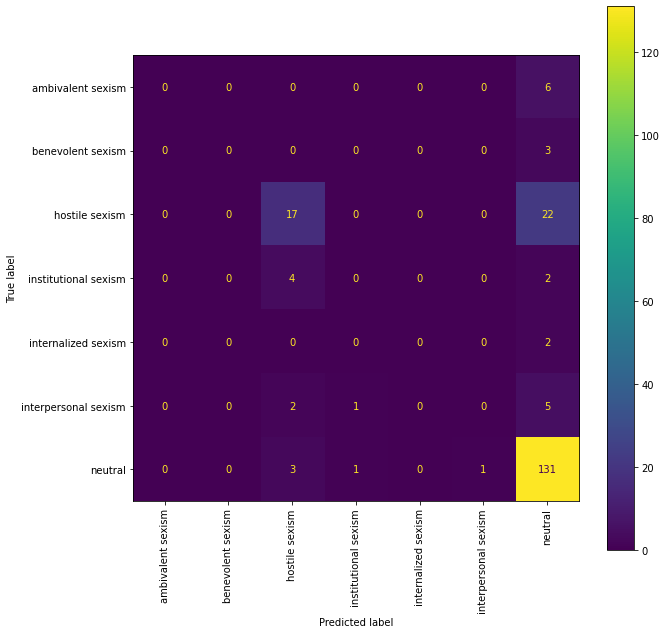

In [ ]:
def print_confusion(classifier):
    fig, ax = plt.subplots(figsize=(10,10))
    plot_confusion_matrix(classifier.log_reg, classifier.devX, classifier.devY, ax=ax, xticks_rotation="vertical", values_format="d")
    plt.show()

print_confusion(classifier)

In [ ]:
# classifier.printWeights(n=25)

In [ ]:
def analyze(classifier):

    probs=classifier.log_reg.predict_proba(classifier.devX)
    predicts=classifier.log_reg.predict(classifier.devX)

    classes={}
    for idx, lab in enumerate(classifier.log_reg.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != classifier.devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        idd=classifier.devOrig[k][0]
        text=classifier.devOrig[k][2]
        frame.append([idd, v, classifier.devY[k], predicts[k], text])

    df=pd.DataFrame(frame, columns=["id", "P(predicted class confidence)", "Human label", "Prediction", "Text"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))


In [ ]:
analyze(classifier)

,id,P(predicted class confidence),Human label,Prediction,Text
0,rqy9xe,0.997062,hostile sexism,neutral,Just went through the FDS sub.: Being a naive who just turned 18 i have no idea about what the fuck is going on. I mean yeah you gotta be careful out there but that sub is like downright brutal. I've never dated but seeing that make me feel I'd never want to. I scared lol.\n
1,sw2c96,0.995307,hostile sexism,neutral,"MEN DO NOT LET THESE WOMEN PLAY YOU! My guys, I don't know what's your opinion on this but, let me know in the comments, I found this from Titus Ellis Smith channel. See you around!: [https://www.youtube.com/watch?v=4\\_12wCuA7ZA](https://www.youtube.com/watch?v=4_12wCuA7ZA)\n"
2,tbwrn8,0.994910,hostile sexism,neutral,Do you believe mens rights are more jeopardized than womens rights?: \n\n[View Poll](https://www.reddit.com/poll/tc8ctk)\n
3,te1nhv,0.993952,hostile sexism,neutral,"Men of reddit, what is your creepy stalker ex story: Have you had one?\n"
4,pdfjo5,0.990206,benevolent sexism,neutral,My ex a single mom with kids.: I am a single male age 35 and I was dating a single woman age 32 for about 4 or 5 months who had two kids ages 9 and 7 both of them boys. While she was in college she dated a guy named Bradley who basically did a 3 and half year smash and dash and then he left her flat with two aforementioned kids. Anyhow I just recently came on the scene and fell instantly smitt...
5,taassd,0.989558,institutional sexism,neutral,"Rape case: Ladies, I need some guidance. Please note this may contain triggers for those of you who have been raped or otherwise harmed by a depraved person masquerading as a male human. I will keep this very short &amp; sweet. \n\n6 years ago I was raped. The perpetrator admitted to it in a text to me. His exact words were: \n\n\""It's my fault, you said no and I didn't listen.\""\n\n\""But I'm ..."
6,tbgvlq,0.988085,interpersonal sexism,neutral,"hey guys should I give a chance to a girl who had rejected me previously?: In high school this girl didn't even gave a chance of friendly conversation like she was some queen or some celebrity. Now i have made big, now things are different.so now this bitch acts as if nothing had happened and now as if i have gained respect in her eyes. she is trying to have conversation normally now. What sho..."
7,t8toyn,0.986648,institutional sexism,hostile sexism,"Today is gender pay gap propaganda day in Germany: I hate it. How can anybody be so retarded to believe this lie? They even calculated the date wrong and changed the definition afterwards, when some people noticed it. Today a saw feminists shift the goal posts even further than the last years. Feminist: Women earn 18% less than men. That's sexist! Non-retarded person: That's comparing apples t..."
8,o0m6go,0.977817,ambivalent sexism,neutral,"Men\u2019s advice. If you\u2019re hung up on one person who is not invested in you, think of the regret you will eventually have over the precious time, opportunities, and emotional energy you wasted: There were several girls in college that I spent far too long being fixated on, girls who weren\u2019t even that spectacular or beautiful as I look back now. However, when in the haze of lust (wh..."
9,tdggfr,0.977258,benevolent sexism,neutral,Which woman age is most attractive for men?: Tell me your answer and age \ud83d\ude09\n
